# Analysis of hand drawn maps

This script is for analysing hand drawn maps of the Willunga sub-basin based on manual water table mapping exercise and survey.

Rasters are made in ArcGis using the hand drawn contour data and converting it to a raster using "Topo2Raster" tool

Script is run in the `conda activate geo_env` enviroment

## Import packages

In [1]:
from __future__ import division

#import affine
#import contextily
import fiona
import geopandas as gpd
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import FormatStrFormatter
import os
import numpy as np
import pyproj
import pandas as pd

import rasterio 
from rasterio.crs import CRS
from rasterio.enums import Resampling
from rasterio.features import rasterize
import rasterio.mask
from rasterio.plot import show
from rasterio.transform import from_bounds
from rasterio import shutil as rio_shutil
from rasterio.vrt import WarpedVRT
from rasterio import Affine

from requests import Request
from scipy.interpolate import interpn
from scipy.interpolate import griddata
from scipy import stats
import sys
import shapely
from shapely.geometry import Point
from shapely.geometry import mapping, Polygon
import string
from owslib.wcs import WebCoverageService



%matplotlib inline

## Define functions

#### Pull in the raster files - function

In [2]:
def get_raster(raster_fname):

    wt_rstr = rasterio.open(raster_fname)

    with rasterio.open(raster_fname) as grd:
        wt_ar = grd.read()[0,:,:]
        wt_meta = grd.profile   
        wt_bounds = grd.bounds
        wt_res = grd.res

    mask = np.zeros_like(wt_ar)
    nrows,ncols = np.shape(mask)

    return wt_rstr, wt_ar, wt_meta, wt_bounds, wt_res, mask, nrows, ncols

#### Change raster to utm and save in new folder - function

In [3]:
def reproject_raster(in_path, out_path, dst_crs):

    """
    """
    # reproject raster to project crs
    with rasterio.open(in_path) as src:
        src_crs = src.crs
        transform, width, height = rasterio.warp.calculate_default_transform(src_crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()

        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height})

        with rasterio.open(out_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                rasterio.warp.reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)
    return(out_path)

#### Get the well indices for the raster at every well location 

In [4]:
def get_well_ixs(df_head_at_wells_from_rstr, ncols_utm, nrows_utm, wt_meta_utm, wells_df_2_gdf):
    
    ## Get the centroid locations for every pixel
    cols, rows = np.meshgrid(np.arange(ncols_utm), np.arange(nrows_utm))
    xs, ys = rasterio.transform.xy(wt_meta_utm['transform'], rows, cols)
    X_array = np.array(xs)
    Y_array = np.array(ys)
    
    ## Calculate the distance from each well to every cell in order to get the well indexes
    well_ixs = []

    for ix in df_head_at_wells_from_rstr.index:

        e_well = wells_df_2_gdf.loc[ix, "mga_easting"]
        n_well = wells_df_2_gdf.loc[ix, "mga_northing"]

        c = np.sqrt((Y_array - n_well)**2 + (X_array - e_well)**2)
        well_ixs.append(np.unravel_index(np.argmin(c, axis=None), c.shape))
    
    return well_ixs

#### Get the head results for the raster

In [5]:
def get_raster_head_per_well(well_ixs, wt_ar_utm): 
    
    raster_head_vals = []

    for ix in well_ixs:
        raster_head_vals.append(wt_ar_utm[ix[0], ix[1]])
        
    return raster_head_vals

## Projection and colour set ups

In [6]:
wgs84 = pyproj.CRS('epsg:4326')
utm   = pyproj.CRS('epsg:32754')
gda94 = pyproj.CRS('epsg:4283')
austalbers = pyproj.CRS('epsg:3577')

wt_cmap = "coolwarm"
dem_cmap = "terrain"

## Pull in the well data


In [7]:
outputdatapath = r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\output_data'

# In this dataframe are the original data
wells_df_1 = pd.read_csv(os.path.join(outputdatapath, "well_summary_gdf_ss_a1.csv"))

# In this dataframe I have added three new measurements BUT I have also removed some rswl values
wells_df_2 = pd.read_csv(os.path.join(outputdatapath, "well_summary_gdf_ss_c.csv"))

wells_df_1.index = wells_df_1.DHNO
wells_df_2.index = wells_df_2.DHNO

# Drop some columns to make it more manageable
wells_df_2 = wells_df_2.drop(columns=['Unit_No', 'Unit_Number', 'dh_name', 'network',
       'Obs_No', 'drillhole_class', 'water_point_type_code', 
       'Orig_drilled_depth', 'Orig_drilled_date', 
       'max_drill_date', 'late_open_depth', 'late_open_date', 'late_permit_no',
       'cased_to', 'case_min_diam',  'latest_status',
       'latest_status_date', 
       'EC', 'salinity_date', 'pH', 'pH_date', 'yield', 'yield_date',
        'long_degrees',
       'long_minutes', 'long_seconds', 'lat_degrees', 'lat_minutes',
       'lat_seconds', 'hundred', 'plan', 'parcel', 'Title', 'map_250k', 'map_100k', 'map_50k',
       'map_10k', 'map_2_5k', 'map_1k', 'water_info', 'salinity',
       'water_chemistry', 'geophys_log', 'drill_log', 'lith_log', 'geometry',
       'Datetime'])

## Make wells into geodataframe

In [8]:
# I've been fiddling around with the way to get the geometry but keep 
# getting Shapely error, not sure how to resolve but it doesn't seem to be a problem for now

geometry = []

for ix in wells_df_2.index:
    x = wells_df_2.loc[ix, "decimal_long"]
    y = wells_df_2.loc[ix, "neg_decimal_lat"]
    geometry.append(Point(x,y))

wells_df_2['geometry'] = geometry
wells_df_2_gdf = gpd.GeoDataFrame(wells_df_2, geometry='geometry', crs= 'epsg:4283')

C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


## Pull in shape file of study area extent

In [9]:
study_extent_path = os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\study_extent', 'study_extent.shp')
study_area_shp = gpd.read_file(study_extent_path)
# Change to utm
study_area_shp_utm = study_area_shp.to_crs(utm)

## Plot the study area and wells

Text(68.02985398054291, 0.5, 'Northing')

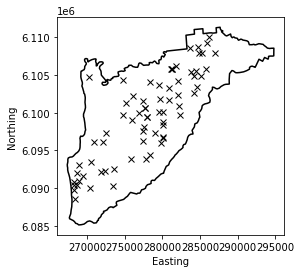

In [10]:
fig, (ax1) = plt.subplots(1, 1)
ax1.plot(wells_df_2_gdf['mga_easting'], wells_df_2_gdf['mga_northing'], "kx")
study_area_shp_utm.exterior.plot(ax=ax1, color="k", label="Study area")

plt.xlabel("Easting")
plt.ylabel("Northing")

## Check files in folder

In [11]:
fldr = r'C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters'

hand_output_raster_list = []
for file in os.listdir(fldr):
    if file.endswith(".tif"):
        hand_output_raster_list.append(file)
    else:
        pass
    
print(hand_output_raster_list)

['ref_001_raster.tif', 'ref_002_raster.tif', 'ref_003_raster.tif', 'ref_008_raster.tif', 'ref_009_raster.tif']


## Set up my database

In [12]:
# Results for estimated head at every well location based on the rasterised results
df_head_at_wells_from_rstr = pd.DataFrame()
estimated_rasters = []
estimated_arrays = []

meta_rs = []
bounds_rs = []
res_rs = []

rstr_names = []
rstr_fnames = []

## LOOP TO PULL IN HAND DRAWN RASTER DATA

In [13]:
rstr_i = 0


for rstr_i in range(len(hand_output_raster_list)):

    # Put in loop but for now separate to test

    name_raster = hand_output_raster_list[rstr_i][:-11]
    raster_fname = os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters', hand_output_raster_list[rstr_i])
    print(raster_fname)
    print(name_raster)

    # Realign and save as UTM raster if I have not already done this

    in_path = raster_fname
    out_path = os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\utm_rasters', hand_output_raster_list[rstr_i])
    dst_crs = utm

    if os.path.isfile(out_path):
        pass
    else: 
        reproject_raster(in_path, out_path, dst_crs)

    # Pull in the utm raster file 

    wt_rstr_utm, wt_ar_utm, wt_meta_utm, wt_bounds_utm, wt_res_utm, mask, nrows_utm, ncols_utm = get_raster(out_path)

    # Add these to the databases

    estimated_rasters.append(wt_rstr_utm)
    estimated_arrays.append(wt_ar_utm)
    meta_rs.append(wt_meta_utm)
    bounds_rs.append(wt_bounds_utm)
    res_rs.append(wt_res_utm)
    rstr_names.append(name_raster)    
    rstr_fnames.append(raster_fname)


C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\ref_001_raster.tif
ref_001
C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\ref_002_raster.tif
ref_002
C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\ref_003_raster.tif
ref_003
C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\ref_008_raster.tif
ref_008
C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\ref_009_raster.tif
ref_009


In [14]:
print(np.max(estimated_arrays[0]))
print(np.max(estimated_arrays[1]))
print(np.max(estimated_arrays[2]))
print(np.max(estimated_arrays[3]))
print(np.max(estimated_arrays[4]))

358.0
268.0
264.53348
240.0
237.51234


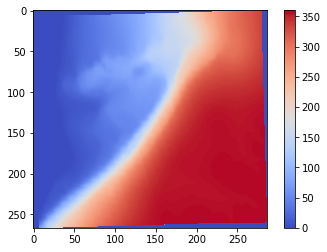

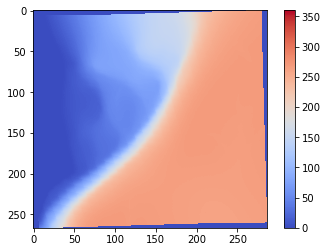

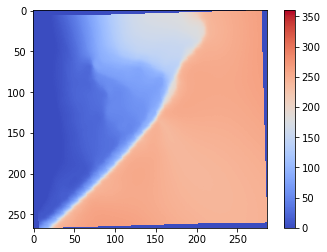

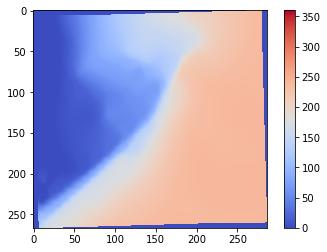

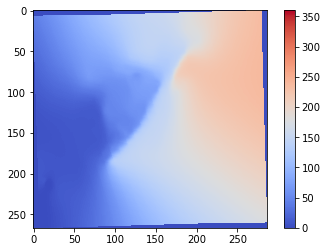

In [15]:


plt.figure()
#plt.subplot(,1,1)
img = plt.imshow(estimated_arrays[0], vmin=0, vmax=360, cmap=wt_cmap)
plt.colorbar(img)

plt.figure()
#plt.subplot(,1,1)
img = plt.imshow(estimated_arrays[1], vmin=0, vmax=360, cmap=wt_cmap)
plt.colorbar(img)


plt.figure()
#plt.subplot(,1,1)
img = plt.imshow(estimated_arrays[2], vmin=0, vmax=360, cmap=wt_cmap)
plt.colorbar(img)


plt.figure()
#plt.subplot(,1,1)
img = plt.imshow(estimated_arrays[3], vmin=0, vmax=360, cmap=wt_cmap)
plt.colorbar(img)


plt.figure()
#plt.subplot(,1,1)
img = plt.imshow(estimated_arrays[4], vmin=0, vmax=360, cmap=wt_cmap)
plt.colorbar(img)

### Add index & rswl to my results dataframe

In [16]:
df_head_at_wells_from_rstr["DHNO"] = wells_df_2.DHNO
df_head_at_wells_from_rstr.index = df_head_at_wells_from_rstr.DHNO
df_head_at_wells_from_rstr["rswl"] = wells_df_2["rswl"]

# Need to add head value where there is a letter

### Fix the indexes that are letters

Put the true value for those that are known and replace those that are unknown with "Unknown"

In [17]:
alphabet = string.ascii_lowercase
list_letters = []

for i in range(9):
    list_letters.append(alphabet[i])
    
wells_letter_df = wells_df_2[wells_df_2["rswl"].isin(list_letters)]

wells_df_1["DHNO"] =  wells_df_1["DHNO"].astype(str)

wells_df_1.index = wells_df_1.DHNO

news = ['new1', 'new2', 'new3', 'new4']

for ix in wells_letter_df.index:
    if ix in news:
        df_head_at_wells_from_rstr.loc[ix, "rswl"] = np.nan
    else:
#        print("start")
 #       print(ix)
        df_head_at_wells_from_rstr.loc[ix, "rswl"] = wells_df_1.loc[ix, "rswl"]

#print(df_head_at_wells_from_rstr['rswl'])

## Get the raster indices for the well locations

In [18]:
well_ixs = get_well_ixs(df_head_at_wells_from_rstr, ncols_utm, nrows_utm, wt_meta_utm, wells_df_2_gdf)
df_head_at_wells_from_rstr["well_ix"] = well_ixs
df_head_at_wells_from_rstr.head()

,DHNO,rswl,well_ix
DHNO,,,
26558,26558,4.09,"(186, 20)"
26565,26565,4.33,"(155, 40)"
26585,26585,18.22,"(144, 56)"
27050,27050,5.54,"(195, 50)"
27063,27063,15.9,"(217, 35)"


## Get the head value from estimated rasters at each well location

In [19]:
for rstr_i in range(len(estimated_arrays)):
    
    raster_head_vals = get_raster_head_per_well(well_ixs, estimated_arrays[rstr_i])
    
    df_head_at_wells_from_rstr[rstr_names[rstr_i]] = raster_head_vals

In [20]:
df_head_at_wells_from_rstr.head()

,DHNO,rswl,well_ix,ref_001,ref_002,ref_003,ref_008,ref_009
DHNO,,,,,,,,
26558,26558,4.09,"(186, 20)",-20.203262,-18.057812,-7.563098,-1.262213,8.995111
26565,26565,4.33,"(155, 40)",1.742489,0.965118,4.902679,5.967878,8.872720
26585,26585,18.22,"(144, 56)",14.311897,15.319687,17.065609,10.868571,10.327415
27050,27050,5.54,"(195, 50)",6.538256,2.622898,9.101677,5.021411,9.544954
27063,27063,15.9,"(217, 35)",10.516420,12.784949,11.679647,13.844901,11.932571


## Plot correlation between measured rswl and estimated rswl from raster

In [21]:
df_head_at_wells_from_rstr.dtypes

DHNO        object
rswl        object
well_ix     object
ref_001    float32
ref_002    float32
ref_003    float32
ref_008    float32
ref_009    float32
dtype: object

ref_001


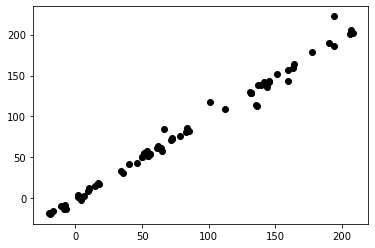

In [22]:
fig = plt.figure()
ax = plt.subplot(111)

rstr_i = 0
name_raster = rstr_names[rstr_i]
print(name_raster)

ax.plot(df_head_at_wells_from_rstr['ref_001'], df_head_at_wells_from_rstr['ref_002'], 'ko')

## Calculate cell by cell averages across all arrays

First, I need to combine all rasters into a single array, that will be the easiest way to do the statistics

In [23]:
a = estimated_arrays[0][0,0]
print(a)

-3.402823e+38


In [24]:
wt_array_3d = np.array([estimated_arrays[0], estimated_arrays[1], estimated_arrays[2], estimated_arrays[3]]) 

In [25]:
wt_array_3d[wt_array_3d==a]=np.nan

In [26]:
print(np.nanmax(wt_array_3d))

358.0


In [27]:
np.shape(wt_array_3d)

max_array = np.amax(wt_array_3d, axis=0)
min_array = np.amin(wt_array_3d, axis=0)
range_array = max_array - min_array
std_array = np.std(wt_array_3d, axis=0)
mean_array = np.mean(wt_array_3d, axis=0)


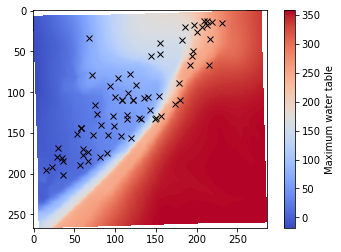

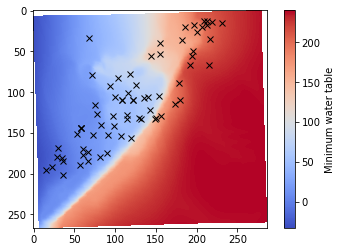

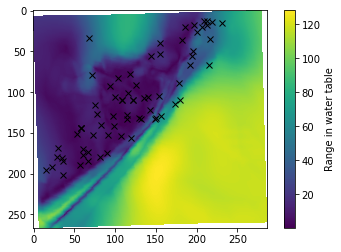

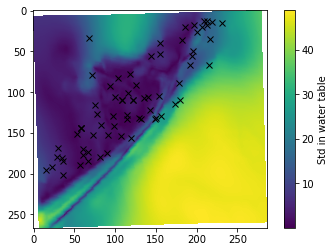

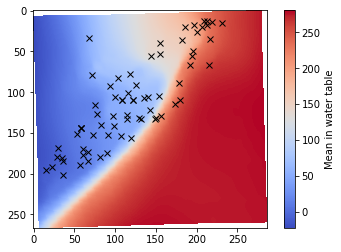

In [28]:
plt.figure()

img = plt.imshow(max_array, cmap=wt_cmap)

plt.colorbar(img, label="Maximum water table")

for i in range(len(well_ixs)):
    plt.plot(well_ixs[i][0],well_ixs[i][1], "kx")
    
#-----

plt.figure()

img = plt.imshow(min_array, cmap=wt_cmap)

plt.colorbar(img, label="Minimum water table")

for i in range(len(well_ixs)):
    plt.plot(well_ixs[i][0],well_ixs[i][1], "kx")
    
#-----
plt.figure()

img = plt.imshow(range_array)

plt.colorbar(img, label="Range in water table")
for i in range(len(well_ixs)):
    plt.plot(well_ixs[i][0],well_ixs[i][1], "kx")
    
#-----
plt.figure()

img = plt.imshow(std_array)

plt.colorbar(img, label="Std in water table")
for i in range(len(well_ixs)):
    plt.plot(well_ixs[i][0],well_ixs[i][1], "kx")
    
#-----
plt.figure()

img = plt.imshow(mean_array, cmap=wt_cmap)

plt.colorbar(img, label="Mean in water table")

for i in range(len(well_ixs)):
    plt.plot(well_ixs[i][0],well_ixs[i][1], "kx")
    
#-----

## Looking at variability in estimate at wells

In [29]:
for rstr_i in range(len(estimated_arrays)):
    
    raster_head_vals = get_raster_head_per_well(well_ixs, estimated_arrays[rstr_i])
    
    df_head_at_wells_from_rstr[rstr_names[rstr_i]] = raster_head_vals

In [30]:
print(df_head_at_wells_from_rstr.head())
print(rstr_names)
print(df_head_at_wells_from_rstr.columns)


        DHNO   rswl    well_ix    ref_001    ref_002    ref_003    ref_008  \
DHNO                                                                         
26558  26558   4.09  (186, 20) -20.203262 -18.057812  -7.563098  -1.262213   
26565  26565   4.33  (155, 40)   1.742489   0.965118   4.902679   5.967878   
26585  26585  18.22  (144, 56)  14.311897  15.319687  17.065609  10.868571   
27050  27050   5.54  (195, 50)   6.538256   2.622898   9.101677   5.021411   
27063  27063   15.9  (217, 35)  10.516420  12.784949  11.679647  13.844901   

         ref_009  
DHNO              
26558   8.995111  
26565   8.872720  
26585  10.327415  
27050   9.544954  
27063  11.932571  
['ref_001', 'ref_002', 'ref_003', 'ref_008', 'ref_009']
Index(['DHNO', 'rswl', 'well_ix', 'ref_001', 'ref_002', 'ref_003', 'ref_008',
       'ref_009'],
      dtype='object')


First I need to change data type to numeric (maybe do this earlier?)

In [31]:
df_head_at_wells_from_rstr.dtypes

df_head_at_wells_from_rstr[rstr_names].apply(pd.to_numeric)

print(df_head_at_wells_from_rstr.head())

print(df_head_at_wells_from_rstr.dtypes)

        DHNO   rswl    well_ix    ref_001    ref_002    ref_003    ref_008  \
DHNO                                                                         
26558  26558   4.09  (186, 20) -20.203262 -18.057812  -7.563098  -1.262213   
26565  26565   4.33  (155, 40)   1.742489   0.965118   4.902679   5.967878   
26585  26585  18.22  (144, 56)  14.311897  15.319687  17.065609  10.868571   
27050  27050   5.54  (195, 50)   6.538256   2.622898   9.101677   5.021411   
27063  27063   15.9  (217, 35)  10.516420  12.784949  11.679647  13.844901   

         ref_009  
DHNO              
26558   8.995111  
26565   8.872720  
26585  10.327415  
27050   9.544954  
27063  11.932571  
DHNO        object
rswl        object
well_ix     object
ref_001    float32
ref_002    float32
ref_003    float32
ref_008    float32
ref_009    float32
dtype: object


In [32]:
mean_values = df_head_at_wells_from_rstr[rstr_names].mean(axis=1)
print(mean_values)

DHNO
26558      -7.618256
26565       4.490177
26585      13.578636
27050       6.565839
27063      12.151698
             ...    
200678    132.196991
new1       -0.976220
new2      149.284958
new3       10.877525
new4       11.509749
Length: 71, dtype: float32


In [33]:
df_head_at_wells_from_rstr['mean_wells'] = df_head_at_wells_from_rstr[rstr_names].mean(axis=1)
df_head_at_wells_from_rstr['std_wells'] = df_head_at_wells_from_rstr[rstr_names].std(axis=1)
df_head_at_wells_from_rstr.head()

,DHNO,rswl,well_ix,ref_001,ref_002,ref_003,ref_008,ref_009,mean_wells,std_wells
DHNO,,,,,,,,,,
26558,26558,4.09,"(186, 20)",-20.203262,-18.057812,-7.563098,-1.262213,8.995111,-7.618256,12.080697
26565,26565,4.33,"(155, 40)",1.742489,0.965118,4.902679,5.967878,8.872720,4.490177,3.222432
26585,26585,18.22,"(144, 56)",14.311897,15.319687,17.065609,10.868571,10.327415,13.578636,2.900120
27050,27050,5.54,"(195, 50)",6.538256,2.622898,9.101677,5.021411,9.544954,6.565839,2.882638
27063,27063,15.9,"(217, 35)",10.516420,12.784949,11.679647,13.844901,11.932571,12.151698,1.246287


In [34]:
df_head_at_wells_from_rstr.index

Index(['26558', '26565', '26585', '27050', '27063', '27107', '27112', '27113',
       '27117', '27118', '27119', '27121', '27125', '39875', '39932', '40002',
       '40495', '40740', '40794', '42029', '42104', '42108', '42117', '42173',
       '42190', '42279', '43439', '43470', '43490', '44644', '45105', '45276',
       '45418', '45475', '46069', '46129', '46196', '46212', '46229', '46232',
       '46299', '46552', '46725', '46726', '46734', '46736', '131933',
       '142342', '156132', '166221', '166767', '166769', '177637', '179079',
       '179080', '180822', '180838', '182233', '186362', '195701', '196280',
       '196571', '196608', '196609', '200676', '200677', '200678', 'new1',
       'new2', 'new3', 'new4'],
      dtype='object', name='DHNO')

### Plot just based on well number

In [35]:
#df_head_at_wells_from_rstr.loc[wellname, "rswl"]

Text(0, 0.5, 'Head (m)')

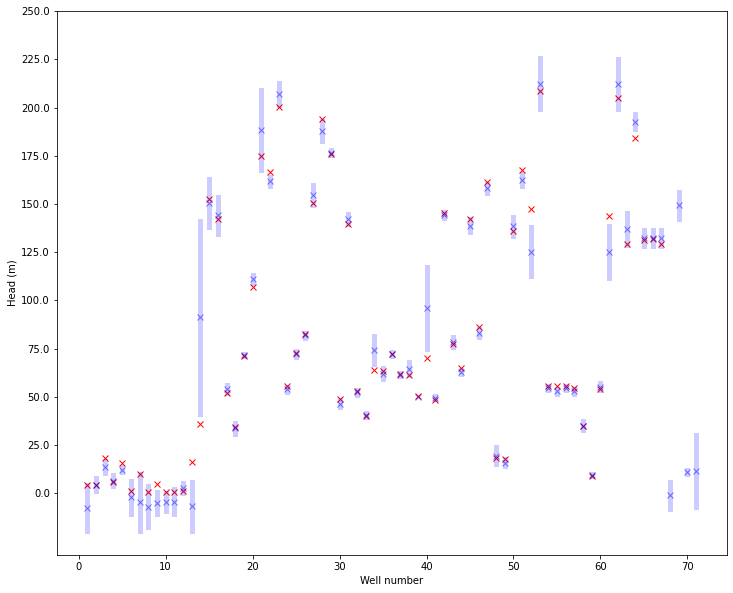

In [54]:
fig = plt.figure(figsize = (12,10))
ax = plt.gca()
rswl_val = []

xval = 1

for idx in df_head_at_wells_from_rstr.index:

    x = []
    y = []
    wellname = idx

    for i in range(len(rstr_names)):
        x.append(xval)
        y.append(df_head_at_wells_from_rstr.loc[wellname, rstr_names[i]])

    std_upper = df_head_at_wells_from_rstr.loc[wellname, "mean_wells"] +  df_head_at_wells_from_rstr.loc[wellname, "std_wells"]
    std_lower = df_head_at_wells_from_rstr.loc[wellname, "mean_wells"] -  df_head_at_wells_from_rstr.loc[wellname, "std_wells"]
    
    rswl_val.append(df_head_at_wells_from_rstr.loc[wellname, "rswl"])
    ax.plot(xval, df_head_at_wells_from_rstr.loc[wellname, "rswl"], "rx", label="Measured (m)")
    ax.plot(xval, df_head_at_wells_from_rstr.loc[wellname, "mean_wells"], "bx", alpha=0.5, label="Mean (m)")
    ax.plot([xval, xval], [std_upper,std_lower], "b-", lw=5, alpha=0.2)

    # Plotting all the data
    #ax.plot(x,y, "kx")
    
    xval += 1
    
#plt.legend()
ticks = np.linspace(0, 250, 11) 
plt.yticks(ticks=ticks, labels=ticks)
plt.xlabel("Well number")
plt.ylabel("Head (m)")

In [37]:
for i in range(len(rswl_val)):
    print(rswl_val[i])
    print(type(rswl_val[i]))

4.09
<class 'str'>
4.33
<class 'str'>
18.22
<class 'str'>
5.54
<class 'str'>
15.9
<class 'str'>
0.98
<class 'str'>
10.15
<class 'str'>
0.55
<class 'str'>
4.55
<class 'str'>
0.45
<class 'str'>
0.5
<class 'str'>
1.12
<class 'str'>
16.11
<class 'numpy.float64'>
35.77
<class 'numpy.float64'>
152.49
<class 'str'>
142.26
<class 'str'>
51.76
<class 'str'>
34.15
<class 'str'>
70.97
<class 'str'>
106.91
<class 'str'>
175.14
<class 'str'>
166.65
<class 'numpy.float64'>
200.48
<class 'str'>
55.52
<class 'str'>
72.62
<class 'str'>
82.42
<class 'str'>
150.52
<class 'str'>
194.24
<class 'str'>
176.09
<class 'str'>
48.78
<class 'str'>
139.64
<class 'str'>
52.74
<class 'str'>
40.12
<class 'str'>
63.87
<class 'str'>
63.48
<class 'str'>
72.42
<class 'str'>
61.81
<class 'str'>
61.13
<class 'str'>
50.21
<class 'str'>
70.07
<class 'numpy.float64'>
48.43
<class 'str'>
145.32
<class 'str'>
77.2
<class 'str'>
65.0
<class 'str'>
142.08
<class 'str'>
86.42
<class 'str'>
161.25
<class 'str'>
18.12
<class 'str'>


### Plot based on measured value

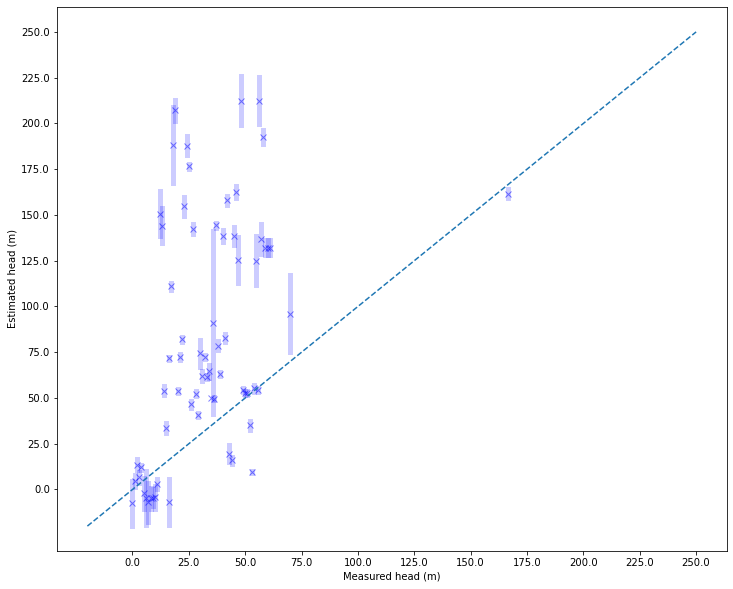

In [38]:
fig = plt.figure(figsize = (12,10))
ax = plt.gca()

for idx in df_head_at_wells_from_rstr.index:

    x = []
    y = []
    wellname = idx

    meas = df_head_at_wells_from_rstr.loc[wellname, "rswl"]
    #print("Measured head is: %s" %meas)

    
    
    for i in range(len(rstr_names)):
        x.append(meas)
        y.append(df_head_at_wells_from_rstr.loc[wellname, rstr_names[i]])

    std_upper = df_head_at_wells_from_rstr.loc[wellname, "mean_wells"] +  df_head_at_wells_from_rstr.loc[wellname, "std_wells"]
    std_lower = df_head_at_wells_from_rstr.loc[wellname, "mean_wells"] -  df_head_at_wells_from_rstr.loc[wellname, "std_wells"]

    ax.plot(meas, df_head_at_wells_from_rstr.loc[wellname, "mean_wells"], "bx", alpha=0.5, label="Mean (m)")
    ax.plot([meas, meas], [std_upper,std_lower], "b-", lw=5, alpha=0.2)

    # Plotting all the data
    #ax.plot(x,y, "kx")
    
    xval += 1
    
#plt.legend()
ticks = np.linspace(0, 250, 11) 
plt.yticks(ticks=ticks, labels=ticks)
plt.xticks(ticks=ticks, labels=ticks)
plt.xlabel("Measured head (m)")
plt.ylabel("Estimated head (m)")

plt.plot(np.linspace(-20,250,100), np.linspace(-20,250,100), '--')

## Plot standard deviation as a function of the well head

First change rswl to numeric

In [39]:
df_head_at_wells_from_rstr["rswl"] = df_head_at_wells_from_rstr["rswl"].apply(pd.to_numeric, errors='raise')
print(df_head_at_wells_from_rstr.head(2))
print(df_head_at_wells_from_rstr.tail(2))

        DHNO  rswl    well_ix    ref_001    ref_002   ref_003   ref_008  \
DHNO                                                                      
26558  26558  4.09  (186, 20) -20.203262 -18.057812 -7.563098 -1.262213   
26565  26565  4.33  (155, 40)   1.742489   0.965118  4.902679  5.967878   

        ref_009  mean_wells  std_wells  
DHNO                                    
26558  8.995111   -7.618256  12.080697  
26565  8.872720    4.490177   3.222432  
      DHNO  rswl    well_ix   ref_001    ref_002    ref_003    ref_008  \
DHNO                                                                     
new3  new3   NaN  (155, 53)  9.999249  11.607593  12.187277  10.535300   
new4  new4   NaN   (68, 34)  4.326117  -1.677065   7.789410   3.097975   

        ref_009  mean_wells  std_wells  
DHNO                                    
new3  10.058204   10.877525   0.975733  
new4  44.012310   11.509749  18.483181  


<AxesSubplot:xlabel='rswl', ylabel='mean_wells'>

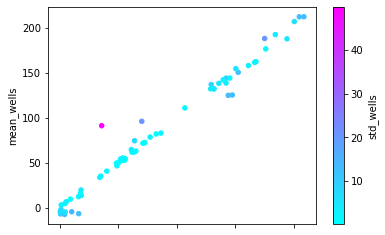

In [40]:
df_head_at_wells_from_rstr.plot.scatter(x = "rswl", y = "mean_wells", 
                                        c = "std_wells", colormap="cool")

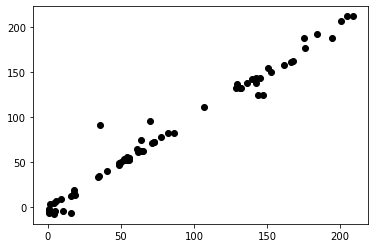

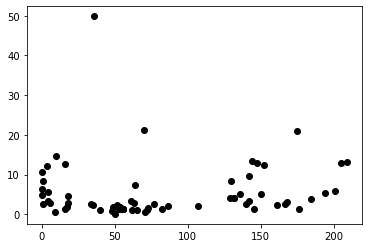

In [41]:
fig = plt.figure()
ax = plt.subplot(111)

ax.plot(df_head_at_wells_from_rstr['rswl'], df_head_at_wells_from_rstr['mean_wells'], 'ko')

fig = plt.figure()
ax = plt.subplot(111)

ax.plot(df_head_at_wells_from_rstr['rswl'], df_head_at_wells_from_rstr['std_wells'], 'ko')

## Pull in the estimated values at well locations

From the survey: https://csiroau.sharepoint.com/:x:/r/sites/PostdocSarahMarshall/Shared%20Documents/General/Willunga/manual_wt_survey.xlsx?d=wedfe971df99a444592a5e00444ba769e&csf=1&web=1&e=NyRcKW 

Save results: C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\survey_results

** Need to save as CSV-UTF-8 data type


** I need to go through the results for the estimates and convert them to numbers, where they are a range, use the mean of that range
    

In [42]:
survey_path = os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\survey_results', "manual_wt_survey.csv")

In [43]:
survey_results = pd.read_csv(survey_path)

In [44]:
#survey_results.columns
#for col in range(len(survey_results.columns)):
 #   print(col)
  #  print(survey_results.columns[col])

22
Please predict the water level for point a on the map (Grid reference A8)
23
Please predict the water level for pointÊbÊon the map (Grid reference C8)
24
Please predict the water level for pointÊcÊon the map (Grid reference B7)
25
Please predict the water level for pointÊdÊon the map (Grid reference C6)
26
Please predict the water level for pointÊeÊon the map (Grid reference E5)
27
Please predict the water level for pointÊfÊon the map (Grid reference F5)
28
Please predict the water level for pointÊgÊon the map (Grid reference G5)
29
Please predict the water level for pointÊhÊon the map (Grid reference G5)
30
Please predict the water level for pointÊiÊon the map (Grid reference H2)
31
Please predict the water level for pointÊjÊon the map (Grid reference I2)

In [45]:
wt_q_idxs = [22,23,24,25,26,27,28,29,30]
wt_q_letters = ['a','b','c','d','e','f','g','h','i']

wt_q_idxs_dict = {'a': 22, 'b': 23, 'c': 24, 'd': 25, 'e': 26, 'f': 27, 'g': 28, 'h': 29, 'i': 30, 'j': 31}

In [46]:
wt_qs_df = survey_results[survey_results.columns[wt_q_idxs]]

In [47]:
# Replace nans
wt_qs_df = wt_qs_df.replace(-9999,np.nan)

print(wt_qs_df.columns)

Index(['Please predict the water level for point a on the map (Grid reference A8)',
       'Please predict the water level for pointÊbÊon the map (Grid reference C8)',
       'Please predict the water level for pointÊcÊon the map (Grid reference B7)',
       'Please predict the water level for pointÊdÊon the map (Grid reference C6)',
       'Please predict the water level for pointÊeÊon the map (Grid reference E5)',
       'Please predict the water level for pointÊfÊon the map (Grid reference F5)',
       'Please predict the water level for pointÊgÊon the map (Grid reference G5)',
       'Please predict the water level for pointÊhÊon the map (Grid reference G5)',
       'Please predict the water level for pointÊiÊon the map (Grid reference H2)'],
      dtype='object')


In [48]:
well_names_guessed = ["27125", "39875", "new1", "new3", "new4", "180822", "new2", "46232", "42108"]

wt_qs_df.columns = well_names_guessed
print(wt_qs_df)

    27125  39875  new1  new3  new4  180822   new2  46232  42108
0     5.0  100.0     7     3  54.0      63  152.0   99.0    172
1     1.0  100.0     7    12  55.0      58  150.0   90.0    170
2     3.0   50.0     6    12   8.0      54  125.0   85.0    165
3     7.0  100.0     5    10  10.0      55  150.0  110.0    165
4     1.5    5.0     4    10   4.0      54  147.0   77.0    162
5     2.0  150.0     4    12   6.0      56  150.0  100.0    162
6     5.0   65.0     5    10   4.0      54  150.0  130.0    164
7     3.0   90.0     7    11   5.0      57  135.0  110.0    164
8     5.0   30.0     5    10  10.0      55   80.0   80.0    170
9     1.0   20.0     5    15   1.0      56   75.0   73.0    160
10    5.0   50.0     5    10   2.0      56  175.0  125.0    163
11   20.0  200.0    10    50   0.0      30  200.0  200.0    225
12    1.0   10.0     5    12  30.0      55   68.0   71.0    166
13    1.0   30.0     5    13   5.0      55   92.0   88.0    164
14    1.0   22.0     5    12   1.0      

### Plot - compare estimated values to rasters

In [49]:
wt_qs_df[well_names_guessed[0]].mean()
wt_qs_df[well_names_guessed[0]].std()


18.866282349382182

In [50]:
wt_qs_df.loc[0,"27125"]

5.0

27125
39875
new1
new3
new4
180822
new2
46232
42108


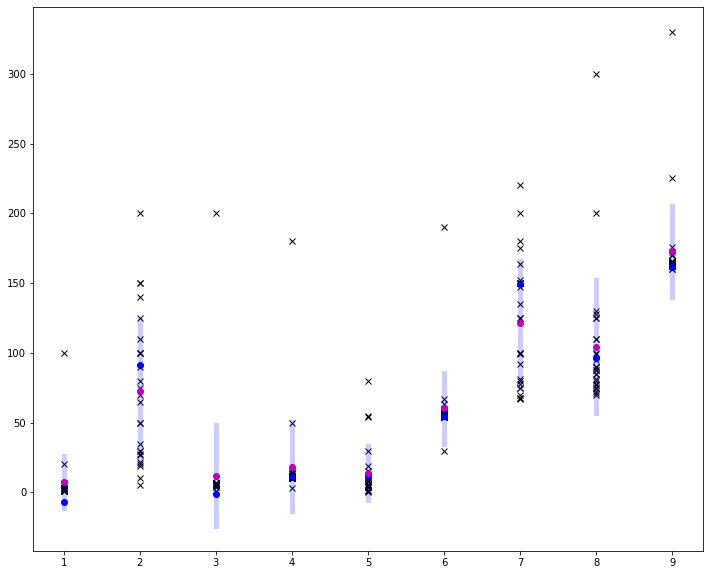

In [51]:
fig = plt.figure(figsize = (12,10))
ax = plt.gca()

xval = 1

for idx in well_names_guessed:

    x = []
    y = []
    wellname = idx
    print(idx)
    
    for i in range(len(wt_qs_df)):
        x.append(xval)
        y.append(wt_qs_df.loc[i,idx])
        
        
    plt.plot(x,y,"kx")
    
    std_upper = wt_qs_df[idx].mean() +  wt_qs_df[idx].std()
    std_lower = wt_qs_df[idx].mean() -  wt_qs_df[idx].std()
    ax.plot([xval, xval], [std_upper,std_lower], "b-", lw=5, alpha=0.2)
    
    ax.plot(xval, df_head_at_wells_from_rstr.loc[wellname, "mean_wells"], "bo", alpha=1.0, label="Mean from rasers (m)")
    ax.plot(xval, wt_qs_df[idx].mean(), "mo", alpha=1.0, label="Mean from guesses (m)")

    
    xval += 1

Text(0, 0.5, 'Head estimated from rasters at wells')

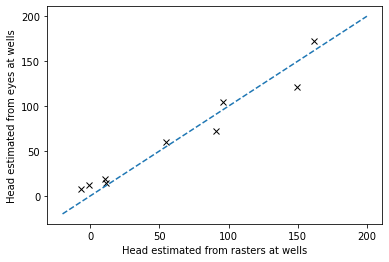

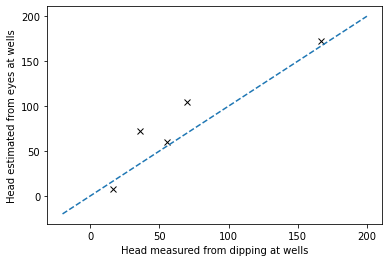

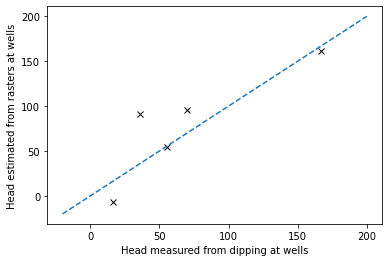

In [52]:
plt.figure()

for idx in wt_qs_df.columns:
    x = df_head_at_wells_from_rstr.loc[idx, "mean_wells"]
    y = wt_qs_df[idx].mean()
    
    plt.plot(x,y,'kx')
    
plt.plot(np.linspace(-20, 200, 20), np.linspace(-20, 200, 20), '--')
plt.xlabel("Head estimated from rasters at wells")
plt.ylabel("Head estimated from eyes at wells")

plt.figure()

for idx in wt_qs_df.columns:
    x = df_head_at_wells_from_rstr.loc[idx, "rswl"]
    y = wt_qs_df[idx].mean()
    
    plt.plot(x,y,'kx')
    
plt.plot(np.linspace(-20, 200, 20), np.linspace(-20, 200, 20), '--')
plt.xlabel("Head measured from dipping at wells")
plt.ylabel("Head estimated from eyes at wells")

plt.figure()

for idx in wt_qs_df.columns:
    x = df_head_at_wells_from_rstr.loc[idx, "rswl"]
    y = df_head_at_wells_from_rstr.loc[idx, "mean_wells"]
    
    plt.plot(x,y,'kx')
    
plt.plot(np.linspace(-20, 200, 20), np.linspace(-20, 200, 20), '--')
plt.xlabel("Head measured from dipping at wells")
plt.ylabel("Head estimated from rasters at wells")

Text(0, 0.5, 'Head (m)')

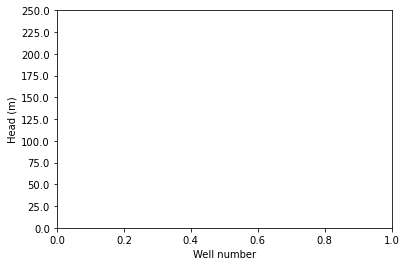

In [53]:
# Plotting all the data
#ax.plot(x,y, "kx")
    
    
    
#plt.legend()
ticks = np.linspace(0, 250, 11) 
plt.yticks(ticks=ticks, labels=ticks)
plt.xlabel("Well number")
plt.ylabel("Head (m)")